In [1]:
import datetime
import pandas as pd
import Factor_classes

%load_ext autoreload
%autoreload 2

In [2]:
# se togli i seguenti ticker da Tickers.json, la strategia migliore diventa random forest:
#"IG.MI", "LDO.MI", "REC.MI",
#"STLAM.MI", "STMMI.MI", "TRN.MI", 
#"AZM.MI", "BPSO.MI", "ERG.MI"

In [3]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stock_data = Factor_classes.StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,AZM.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,BPSO.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLAM.MI,STMMI.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-31,-0.036302,-0.057525,-0.034531,0.033469,-0.047368,-0.036450,-0.061018,0.036468,0.110658,-0.072374,...,-0.027754,-0.033333,-0.061186,0.065526,-0.057827,0.013154,0.028125,-0.053698,0.005291,-0.000776
2023-11-30,0.042084,-0.052874,-0.036249,0.063020,0.044890,-0.052813,0.064156,0.069334,0.051450,-0.068658,...,-0.024532,-0.008276,-0.032923,-0.009901,-0.115216,-0.021172,-0.170888,0.003616,0.042763,-0.006990
2023-12-31,0.117763,0.072312,0.120361,0.046110,0.004627,0.058610,0.217814,0.116129,0.108738,-0.040211,...,0.009145,0.023644,0.071792,0.110556,0.193681,0.081826,0.087169,0.026885,0.056572,0.035198


In [5]:
correlation_matrix = Factor_classes.CorrelationMatrix(returns)
#correlation_matrix.plot_heatmap()

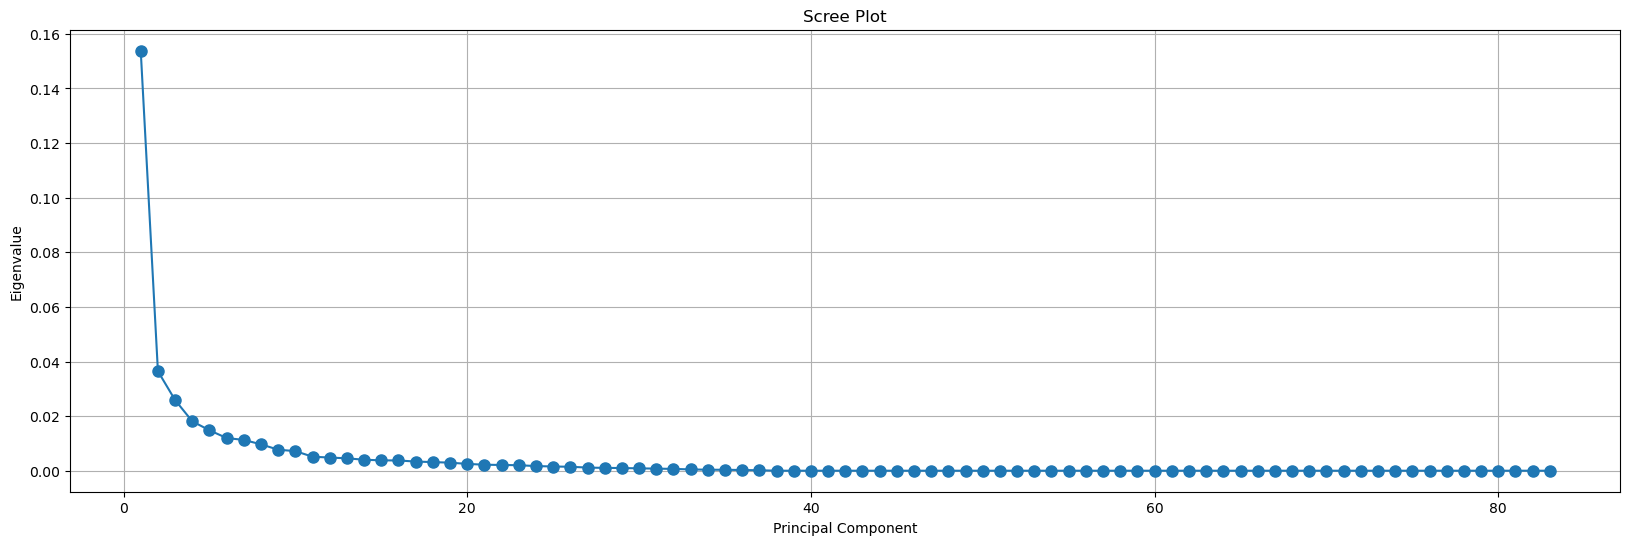

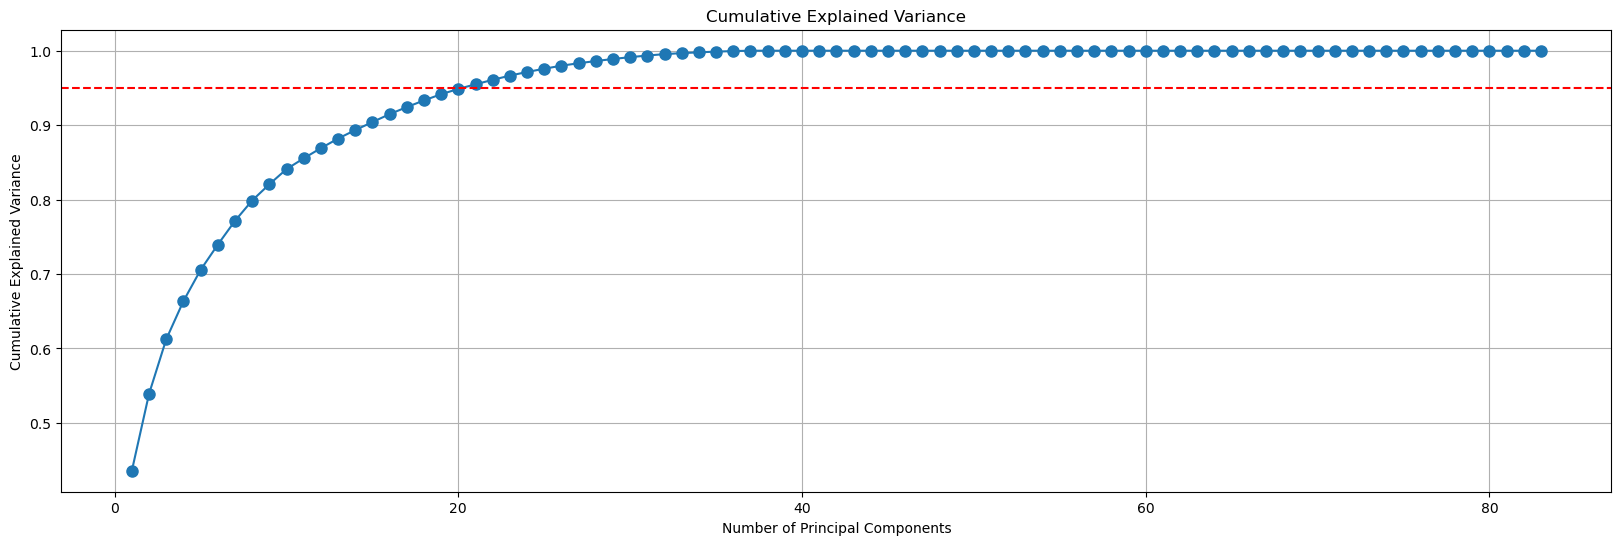

In [6]:
pca_analysis = Factor_classes.ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [7]:
"""
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final
"""

'\nm = 16 #explained variance 95\nwindow_size = 36\nmax_iterations = 10000\nfactor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)\n\nU_m_final = factor_model.U_m_final\nF_final = factor_model.F_final\nB_final = factor_model.B_final\n'

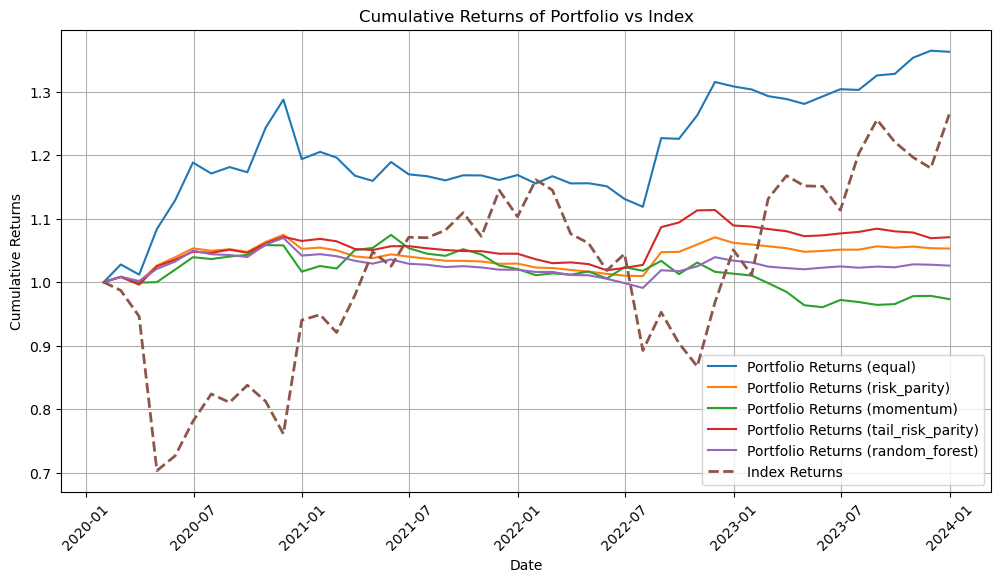

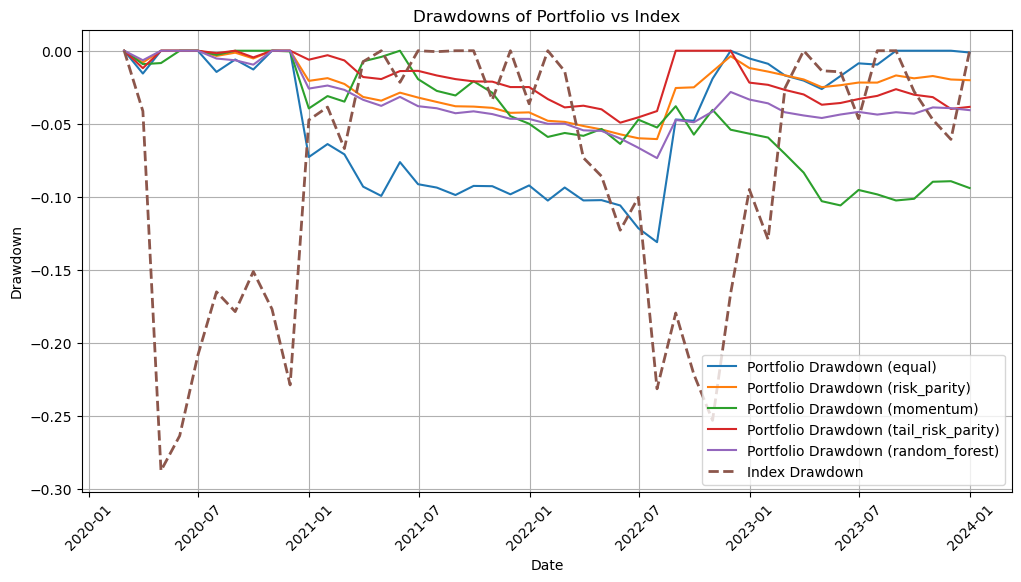

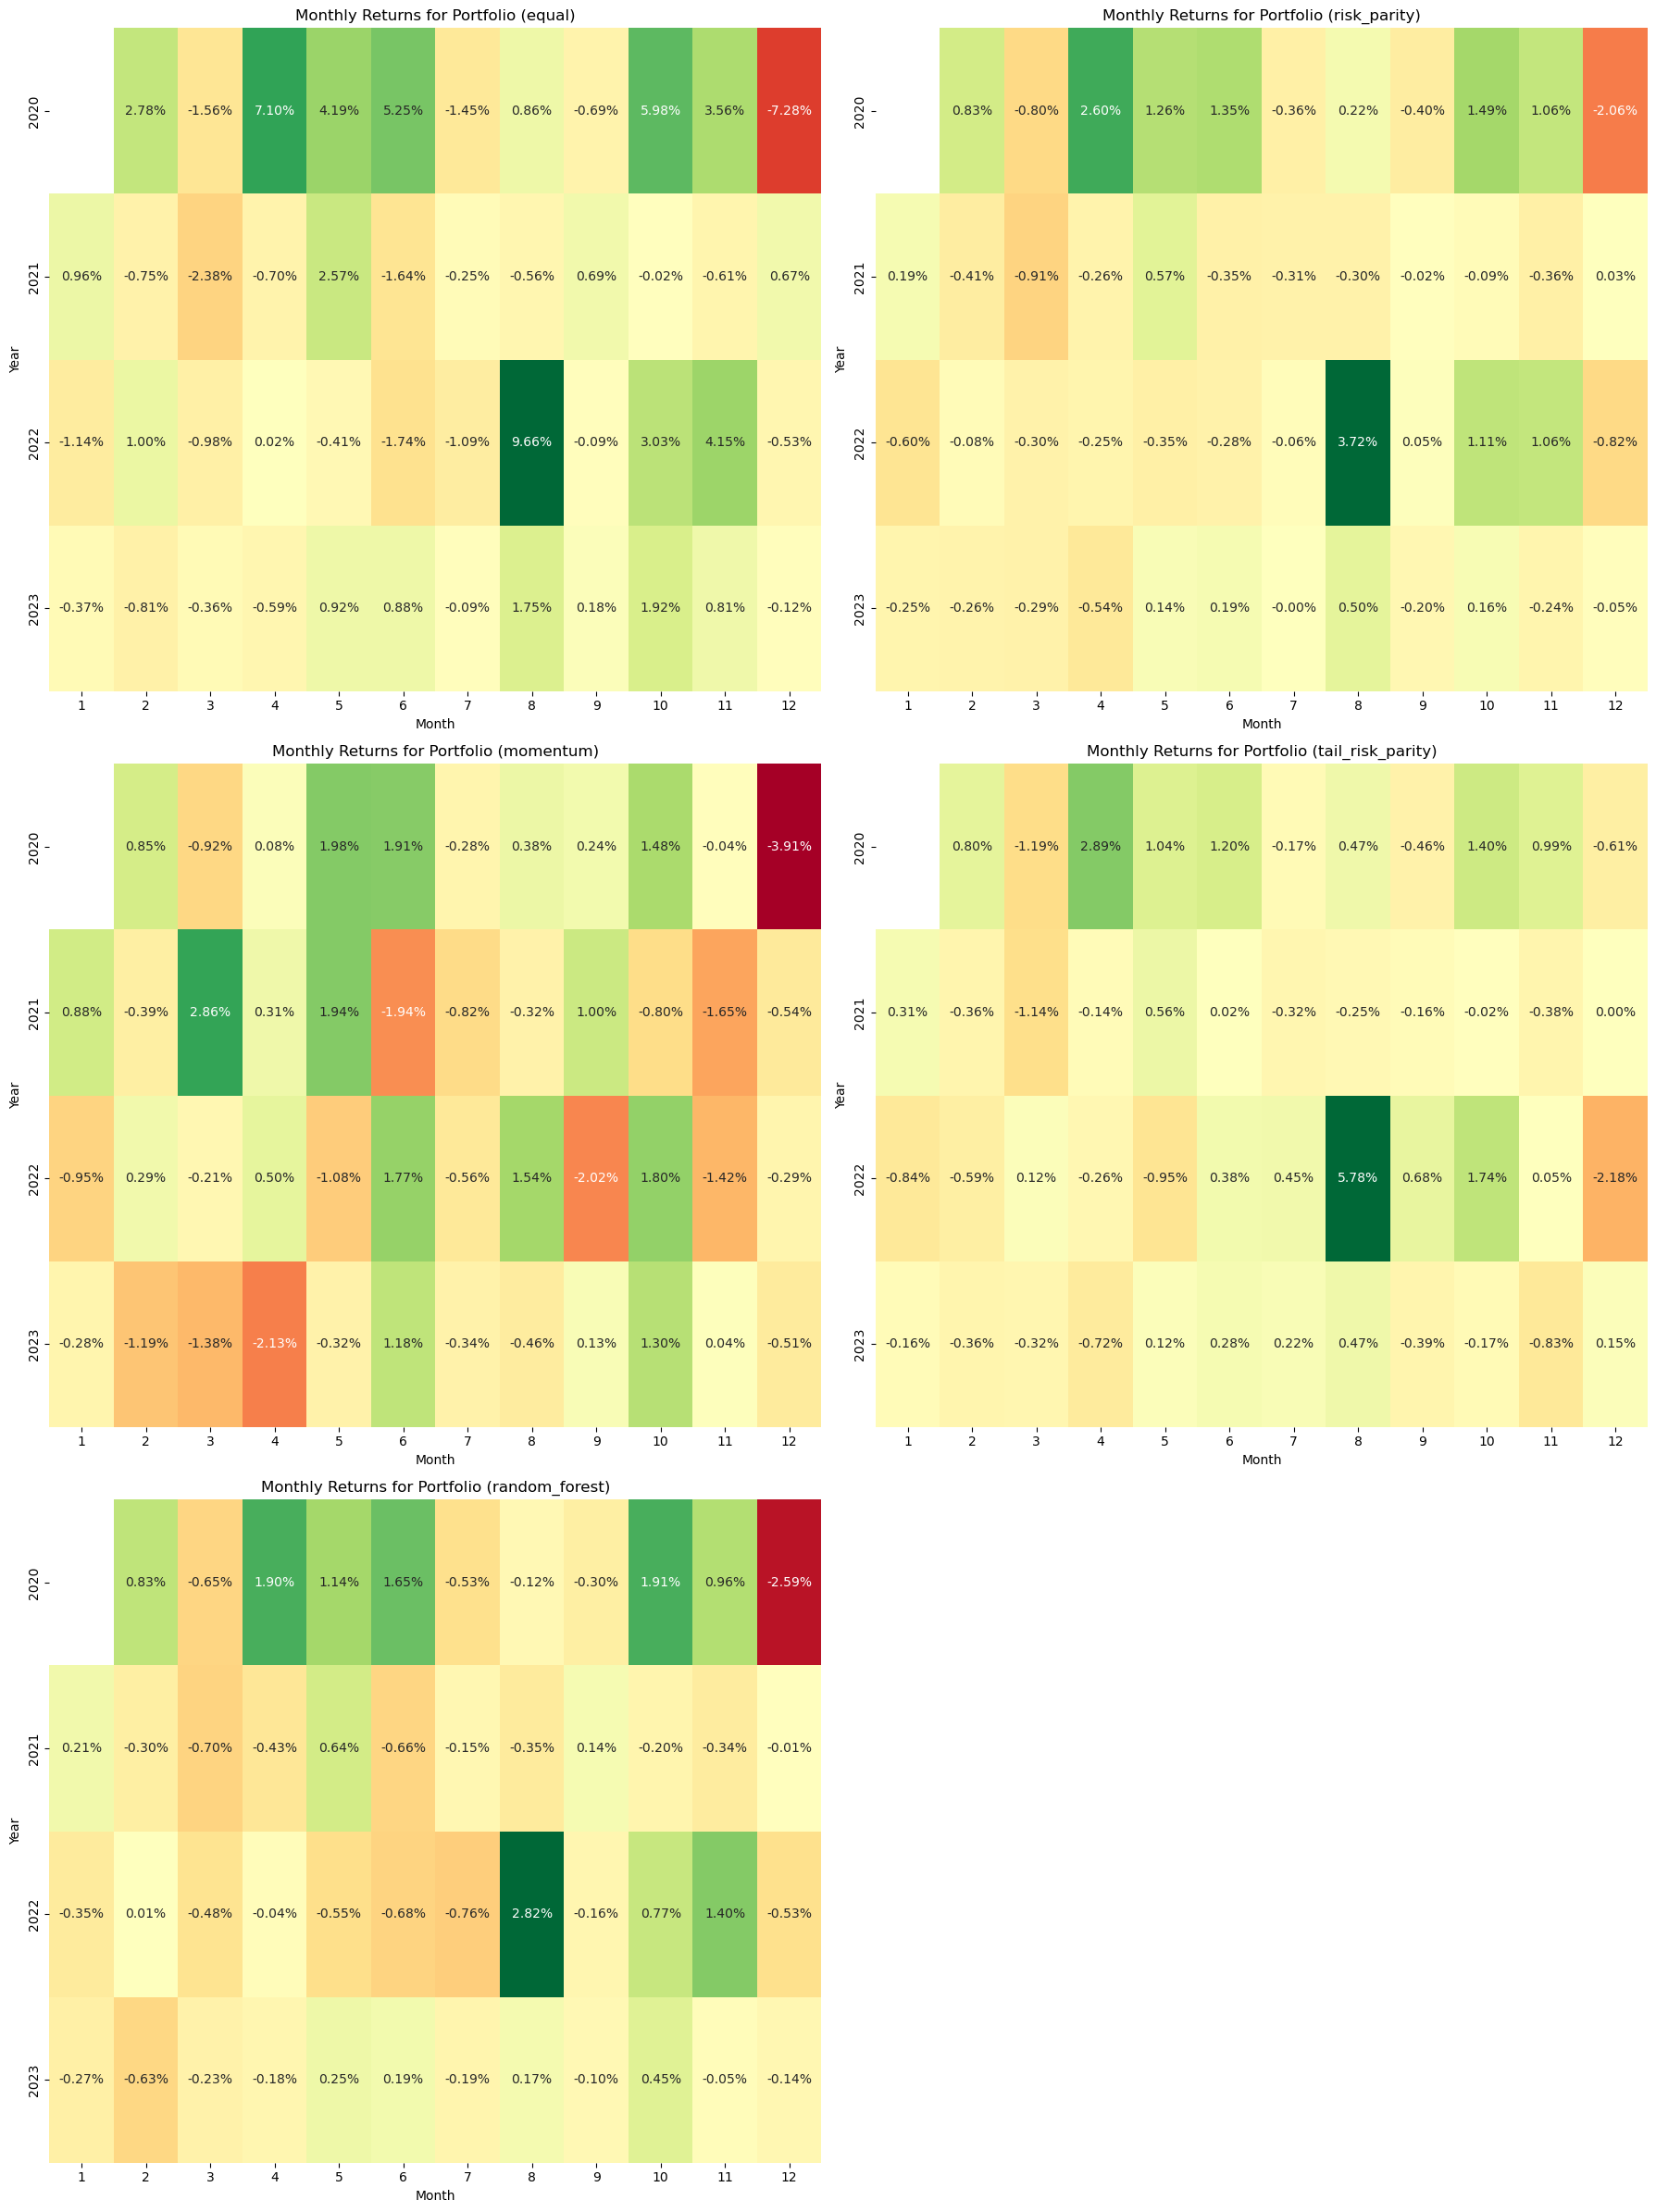

In [8]:
#con window size = 24, risultati ottimi con Random Forest
strategy = Factor_classes.RollingAPCAStrategy(returns, window_size=36, max_iterations=1000, transaction_cost=0.001, slippage=0.001)
index_cum_returns, portfolio_cum_returns = strategy.evaluate_strategies(index_returns)

In [9]:
index_test_rets = pd.DataFrame(index_cum_returns)
index_test_rets.rename(columns={'Open': 'Benchmark'}, inplace=True)

index_test_rets.head(3)

,Benchmark
Date,
2020-02-29,-0.013132
2020-03-31,-0.041379
2020-04-30,-0.256705


In [10]:
index_stats = Factor_classes.FinancialMetrics.summary_stats(index_test_rets)

index_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
Benchmark,0.0616,0.2548,0.1835,-0.3786,6.5755,0.0622,0.1144,0.1551,0.9912,0.1204,0.1672,0.1067,0.2562,-0.2875,0.9179,1,0,0,0,1.7226


In [11]:
portfolio_test_rets = pd.DataFrame(portfolio_cum_returns)

portfolio_test_rets.head(3)

,equal,risk_parity,momentum,tail_risk_parity,random_forest
2020-02-29,0.027804,0.008345,0.008484,0.008020,0.008341
2020-03-31,-0.015620,-0.008048,-0.009189,-0.011925,-0.006516
2020-04-30,0.070953,0.025952,0.000756,0.028905,0.019037


In [12]:
portfolio_stats = Factor_classes.FinancialMetrics.summary_stats(portfolio_test_rets, market=index_test_rets)

portfolio_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
equal,0.0822,0.0947,0.0494,0.7900,5.5874,0.0171,0.0297,0.0380,4.8068,0.5360,1.0436,0.3876,0.7949,-0.1310,2.7670,-0.1252,-0.4055,0.0867,-0.6087,3.3685
risk_parity,0.0132,0.0320,0.0137,1.5767,7.4461,0.0081,0.0086,0.0126,1.6296,-0.5100,-1.1416,-0.2698,-0.5471,-0.0605,0.8738,-0.0415,0.3933,0.0771,-1.4041,1.7850
momentum,-0.0069,0.0452,0.0296,-0.1951,3.4296,0.0200,0.0223,0.0269,-0.3445,-0.7938,-1.1832,-0.3390,-0.6397,-0.1059,-0.2520,-0.0369,0.9732,0.0773,-1.6385,0.9681
tail_risk_parity,0.0176,0.0408,0.0166,2.4716,12.7840,0.0109,0.0058,0.0151,1.6204,-0.2959,-0.6976,-0.2453,-0.4867,-0.0493,1.4346,-0.0382,0.3165,0.0772,-1.3460,1.5106
random_forest,0.0066,0.0305,0.0161,0.6670,5.3675,0.0069,0.0116,0.0135,0.9488,-0.7477,-1.3846,-0.3104,-0.5818,-0.0735,0.3532,-0.0365,0.6252,0.0767,-1.4880,2.6420


# To do

1. Controllare Random Forest
2. Provare diverse tecniche di ML
3. Ottimizzare window size